# 1 - Introduksjon og case

Espen Sirnes  
2025-08-10

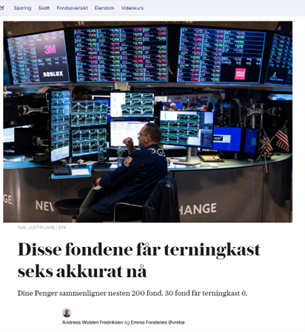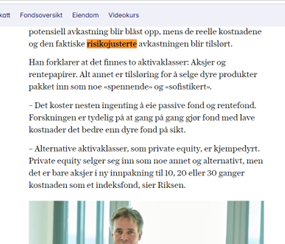

# Introduksjon

## Caset

Hver gruppe får tildelt [tre aksjer](case/portfolios.html)

1.  Bruk historisk avkastning frem til 1. januar 2025 og tilgjengelig
    offentlig informasjon da, slik som års-/kvartalrapporter, og lage en
    portefølje for tre typer investorer:
    1.  Risikoavers
    2.  Risikonøytral
    3.  Risikosøkende
2.  Lag en graf med normalfordelingen og frekvensene til hver av
    aksjene, og kommenter.
3.  Tegn opp i samme diagram
    1.  porteføljefronten
    2.  hver av de tre aksjene
    3.  faktorene
    4.  den optimale tilpasningen.
4.  Regn ut den optimale porteføljen, og forklar hvorfor du bruker eller
    ikke bruker disse vektene.
5.  Bruk forskjellige VaR-modell på de historiske datane, kjør en
    tilbaketest på den (backtesting) og gi din vurdering av modellene.
6.  Hent nye data på aksjene og bruk den til å:
    1.  Evaluer faktisk avkastning
    2.  Tegn opp ny porteføljefront med aksjer og faktorer
    3.  Evaluer VaR-modellene.
7.  Forklar funnene.
    1.  Var det ventet eller uventet?
    2.  Fungerte VaR?
    3.  Gav porteføljen god avkastning?
    4.  Hva kunne vært gjort anderledes?
8.  Faktorene ligger “utfor” (til venstre) for porteføljefronten i
    forelesningsnotat 4 og antakeligvis i din besvarelse. Hvorder er
    dette uventet, og hva kan være årsaken?

All kode må legges ved og være kjørbar. Kjører ikke koden er ikke
oppgaven besvart. Før du leverer bør dere åpne filene dere skal legge
ved besvarelsen på en maskin som ikke har kjørt koden før, for å sjekke
at koden fungerer utenfor miljøet der den er utvikliet. (Dette gjelder
også for mikroopgaven).

## I denne forelesningen

Korte om kursets tema:

-   Forelesning 2: Forventning, nytte, risiko og optimal portefølje for
    én
-   Forelesning 3: Porteføljeteori og matriser
-   Forelesning 4: Faktorer
-   Forelesning 5: Value at Risk (VaR)

# Forelesning 2: Forventning, nytte og risiko

Nyttefunksjonen:

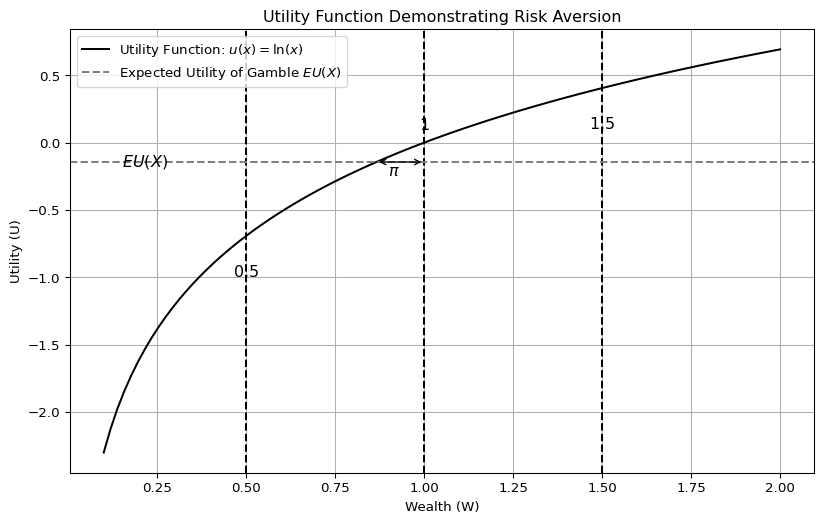

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Logarithmic utility function
def u_func(x):
    return np.log(x)

def x_func(u):
    return np.exp(u)

# Values for wealth and utility
x_vals = np.linspace(0.1, 2, 100)
u_x = u_func(x_vals)

# Gamble outcomes
x_gamble = [0.5, 1.5]  # Outcomes of the gamble
p_gamble = [0.5, 0.5]  # Probabilities

# Certain outcome
x_certain = 1

# Expected utility of the gamble
expected_utility = np.sum(np.array(p_gamble) * u_func(np.array(x_gamble)))

# Plotting the utility function
plt.figure(figsize=(10, 6))
plt.plot(x_vals, u_x, label=r'Utility Function: $u(x) = \ln(x)$', color='black')

# Plotting the certain outcome
plt.axvline(x=x_certain, color='black', linestyle='--')
plt.text(x_certain, u_func(x_certain) + 0.1, "$1$", horizontalalignment='center', fontsize=12)

# Plotting the gamble outcomes
plt.axvline(x=x_gamble[0], color='black', linestyle='--')
plt.axvline(x=x_gamble[1], color='black', linestyle='--')
plt.text(x_gamble[0], u_func(x_gamble[0]) - 0.3, "$0.5$", horizontalalignment='center', fontsize=12)
plt.text(x_gamble[1], u_func(x_gamble[1]) - 0.3, "$1.5$", horizontalalignment='center', fontsize=12)

# Plotting the expected utility
plt.axhline(y=expected_utility, color='gray', linestyle='--', label='Expected Utility of Gamble $EU(X)$')
plt.text(0.15, expected_utility, '$EU(X)$', verticalalignment='center', fontsize=12)

# Risk premium - distance between expected utility and utility of certain outcome
risk_premium = u_func(x_certain) - expected_utility
certainty_equivalence = x_func(expected_utility)
plt.annotate('', xy=(1, expected_utility), xytext=(certainty_equivalence, expected_utility),
             arrowprops=dict(facecolor='black', arrowstyle='<->'))
# Separate annotation for the label (π) without the arrow
plt.annotate(r'$\pi$', xy=(0.9, expected_utility -0.1), fontsize=12)

# Labels and title
plt.title('Utility Function Demonstrating Risk Aversion')
plt.xlabel('Wealth (W)')
plt.ylabel('Utility (U)')
plt.legend()
plt.grid(True)

# Forelesning 3: Porteføljeteori og matriser

Reduserer utvalget:

In [2]:
import numpy as np
import pandas as pd

df = pd.read_pickle('data/stocks.df')
# Defining annual risk free rate. 
rf = df['NOWA_DayLnrate'].mean()*7

isin_with_first_date = df[df['Date'] == df['Date'].min()]['ISIN'].unique()
isin_with_last_date = df[df['Date'] == df['Date'].max()]['ISIN'].unique()
valid_isins = set(isin_with_first_date).intersection(isin_with_last_date)
df = df[df['ISIN'].isin(valid_isins)]

df['Name (ISIN)'] =df['Name'].str.upper().str.strip() + '(' + df['ISIN'] + ')'

# keeping only the most traded shares
res = (
        df.groupby(['Name (ISIN)'])
        .agg({'Turnover': 'sum'})
        .sort_values(by='Turnover', ascending=False)
)
df = df.merge(res.head(4), on=['Name (ISIN)'], 
                                how='inner')
res.head(4)

Lager avkastningsmatrisen:

In [3]:
def get_matrix(df, field):
    """Converts the df to a matrix df that can 
    be used to calculate the covariance matrix"""
    
    import pandas as pd
    df['Date'] = pd.to_datetime(df['Date'])
    df_unique = df.drop_duplicates(
                                    subset=['Date', 'ISIN'])
    pivot_df = df_unique.pivot(index='Date', 
                                    columns='Symbol', 
                                    values=field)

    pivot_df = pivot_df.dropna()

    # Annualized weekly returns
    df_weekly = pivot_df.resample('W').sum()

    return df_weekly

#X is a matrxi with e
X_df = get_matrix(df, 'lnDeltaP') 
X_df = X_df.sort_index()

X_df

512 rows × 4 columns

Finner gjennomsnittsvektoren og varians-kovarians-matrisen:

In [4]:
# Converting X to a numpy array:
X = np.array(X_df)

# Calculating the covariance
cov_matrix = np.cov(X, rowvar=False)

# Calculating the means vector, and reshaping it to a 
# column vector. 

means = np.mean(X, axis=0).reshape((X.shape[1],1))

Definerer porteføljefrontfunksjonen:

In [5]:
ones = np.ones((len(means),1))

A = (ones.T @ np.linalg.inv(cov_matrix) @ ones)[0][0]

B = (ones.T @ np.linalg.inv(cov_matrix) 
                                @ (means-rf))[0][0]

C = ((means.T-rf) @ np.linalg.inv(cov_matrix) 
                                @ (means-rf))[0][0]

def portfolio_front(expected_excess_return, a, b, c):
    r = expected_excess_return
    minimum_variance = (1/a 
            + ((r - abs(b)/a)**2) / (c - b**2/a))
    minimum_volatility = minimum_variance**0.5
    return minimum_volatility

Plotter porteføljefronten:

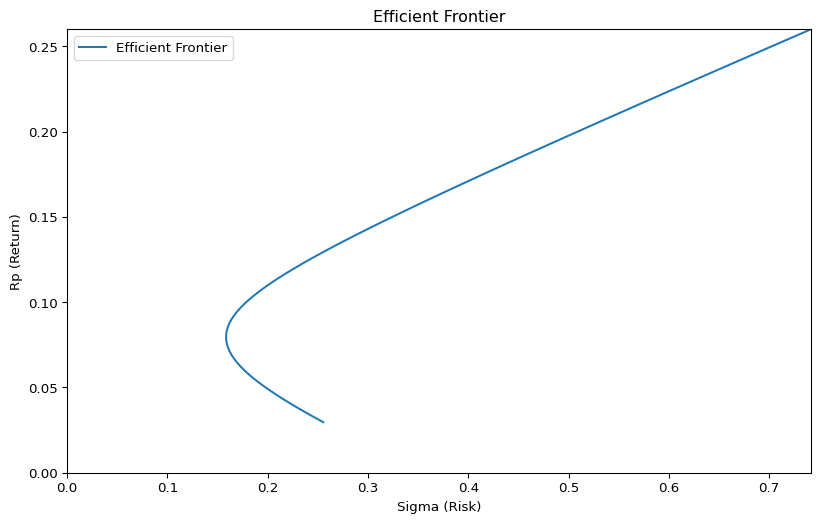

In [6]:
from matplotlib import pyplot as plt
#Creating plot
fig, ax = plt.subplots(figsize=(10, 6))
plot_scale = 52
MAX_AXIS = 0.005
#applying the function
rp_values = np.linspace(0, MAX_AXIS-rf, 100)
sigma_values = portfolio_front(rp_values, A, B, C)

#plotting, after annualizing the weekly data
ax.plot(plot_scale**0.5*(sigma_values), plot_scale*(rp_values+rf), 
                        label='Efficient Frontier')

#plot settings:
ax.set_xlim([0, np.max(sigma_values*plot_scale**0.5)])
ax.set_ylim([0, (np.max(rp_values)+rf)*plot_scale])
ax.set_xlabel('Sigma (Risk)')
ax.set_ylabel('Rp (Return)')
ax.set_title('Efficient Frontier')
ax.legend()

Legger til punkte for den optimale porteføljen:

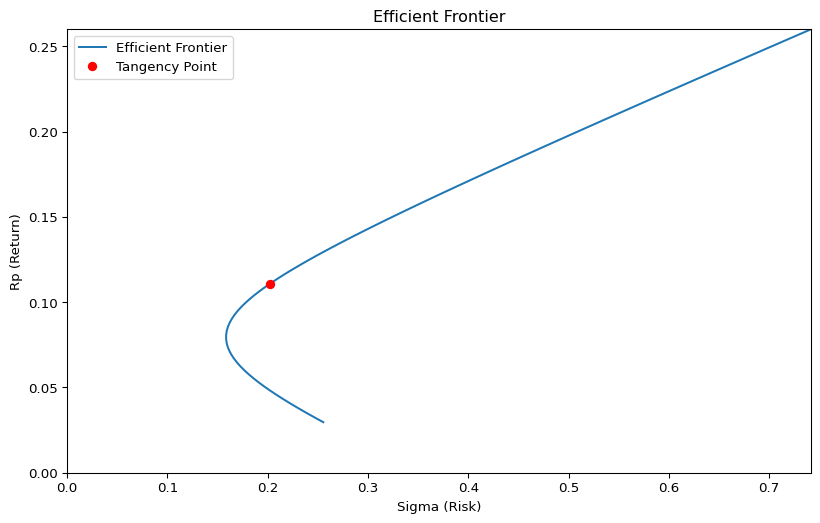

In [7]:
# Calculating the tangency point of the normalized 
# optimal portfolio
tangency_sigma =  portfolio_front(C/B, A, B, C)

#plotting it, after annualizing the weekly data
ax.plot(plot_scale**0.5*tangency_sigma, 
                    plot_scale*(C/B + rf), 
                    'ro',label='Tangency Point')
ax.legend()
fig

## Porteføljefronten med optimal portefølje og tangeringslinje

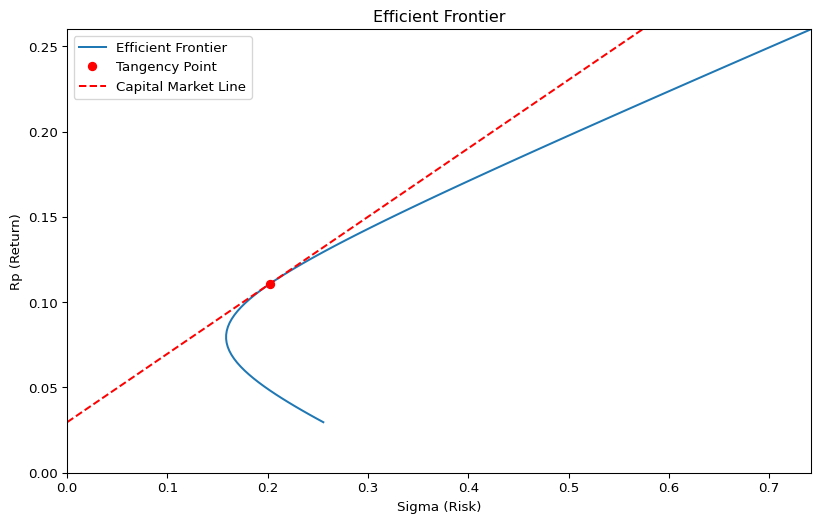

In [8]:
sigma_range = np.linspace(0, np.max(sigma_values), 100)

# Plotting the portfolio front, after annualizing the 
# weekly data
ax.plot(plot_scale**0.5*sigma_range, plot_scale*(rf 
                + sigma_range*(C/B)/tangency_sigma), 
                color='r', linestyle='--', 
                label='Capital Market Line')

ax.legend()

fig

# Forelesning 4: Faktorer

Finner volatilitet og avkastning til faktorene:

In [9]:
import pandas as pd

df = pd.read_pickle('data/factors.df')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df_weekly = df.resample('W').sum()
df_weekly = df_weekly[['SMB', 'HML', 'LIQ', 'MOM']].dropna()
df = df[['SMB', 'HML', 'LIQ', 'MOM']].dropna()
means = df_weekly.mean()*52
std = df_weekly.std()*52**0.5
print(std)
print(means)
df_weekly

SMB    0.140437
HML    0.179257
LIQ    0.152690
MOM    0.209637
dtype: float64
SMB    0.047721
HML    0.142255
LIQ    0.014306
MOM    0.168830
dtype: float64

513 rows × 4 columns

Plotter punktene i grafen fra forrige kapittel:

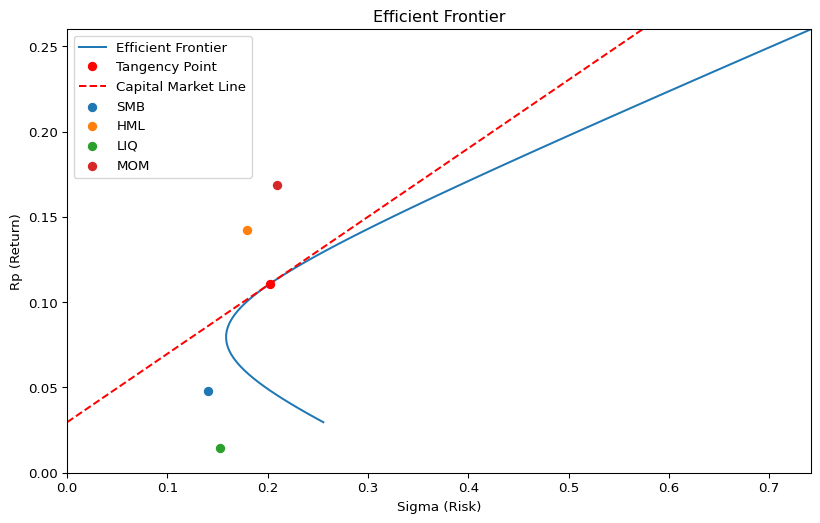

In [10]:
for series in means.index:
        ax.scatter(std[series], means[series], label=series)

ax.legend()

fig

# Forelesning 5: VaR

#### Backtestfunksjonen:

In [11]:
import numpy as np
import pandas as pd
def generate_backtest(f, df, name, estimation_win_size):
    # Initialize lists to store calculated values
    datelist = []
    sigmalist = []
    d95list = []
    d99list = []
    ret = []

    # Iterate over returns to calculate and store VaR and volatility estimates
    for t in range(estimation_win_size, len(df)):
        
        # Record date and current return
        datelist.append(df.index[t].date())
        ret.append(df[name].iloc[t])

        # Extract data from the estimation window (t-estimation_win_size to t-1)
        x = df[name].iloc[t-estimation_win_size:t-1]

        # Apply the provided VaR estimation function using the historical data and past volatility
        d95, d99, sigma = f(x, sigmalist)

        # Append the estimates to their respective lists
        sigmalist.append(sigma)
        d95list.append(d95)
        d99list.append(d99)

    # Return the results as numpy arrays for ease of analysis
    return (np.array(d95list),
            np.array(d99list),
            np.array(sigmalist),
            np.array(datelist),
            np.array(ret))

#### Evalueringsfunksjonen:

In [12]:
import matplotlib.pyplot as plt
def evaluate(plt, d95, d99, ret, dates, heading):
    # Clear the plot area to avoid overlapping plots
    plt.cla()

    # Plot the 95% VaR, 99% VaR, and actual returns
    plt.plot(dates, d95, label='95% Confidence Level')
    plt.plot(dates, d99, label='99% Confidence Level')
    plt.plot(dates, ret, label='Actual Return')

    # Highlight instances where returns breach the 95% VaR
    maxret = max(ret)
    minret = min(ret)

    breaches_95 = np.array([maxret-minret if d > r else 0 for d, r in zip(d95, ret)])
    np.savetxt('breaches.csv',
                    np.concatenate( ([['date','breaches', 'd95', 'd99', 'ret']], 
                                np.array([dates,breaches_95, d95, d99,ret]).T),  
                    axis=0), 
                fmt='%s', delimiter=";")
    plt.bar(dates, breaches_95, bottom=minret, color='gray', alpha=0.5, width=4.0, label='Breaches 95% VaR')

    # Set labels and title
    plt.ylabel('VaR')
    plt.xlabel('Date')
    plt.title(heading)
    plt.xticks(rotation=90)
    plt.legend(loc="lower right")
    plt.subplots_adjust(bottom=0.15)
    plt.show()

    # Calculate and print the breach percentage for each confidence level
    backtest_results = [np.round(sum(d > ret) / len(ret) * 100, 1) for d in [d95, d99]]

    for i, level in enumerate([95, 99]):
        breaches = sum([d95, d99][i] > ret)
        print(f"{heading} with {level}% confidence interval:\n"
              f"Breaches: {breaches}\n"
              f"Backtesting (Realized VaR - % breaches): {backtest_results[i]}%\n")

#### Ulike modeller for volatilitetsestimat:

In [13]:
PVALS = [0.05, 0.01]  # Confidence intervals (95% and 99%)
from scipy.stats import norm

def normal_est(x, sigmalist):
    z = norm.ppf(PVALS)  # Z-scores for the specified confidence levels
    sigma = np.std(x, ddof=1)  # Sample standard deviation
    return z[0] * sigma, z[1] * sigma, sigma

def historical_est(x, sigmalist):
    q95 = abs(np.quantile(x, PVALS[0]))  # 95th percentile of historical losses
    q99 = abs(np.quantile(x, PVALS[1]))  # 99th percentile of historical losses
    return -q95, -q99, None  # VaR values are negative to indicate potential loss

def last_volat(x, sigmalist):
    x = np.array(x)
    z = norm.ppf(PVALS)
    if not sigmalist:  # If sigmalist is empty, use initial standard deviation
        sigma = np.std(x, ddof=1)
    else:  # Update sigma based on past volatility and recent error
        sigma = (0.1 * (x[0] - np.mean(x))**2 + 0.9 * sigmalist[-1]**2)**0.5
    return z[0] * sigma, z[1] * sigma, sigma

#### Evaluering

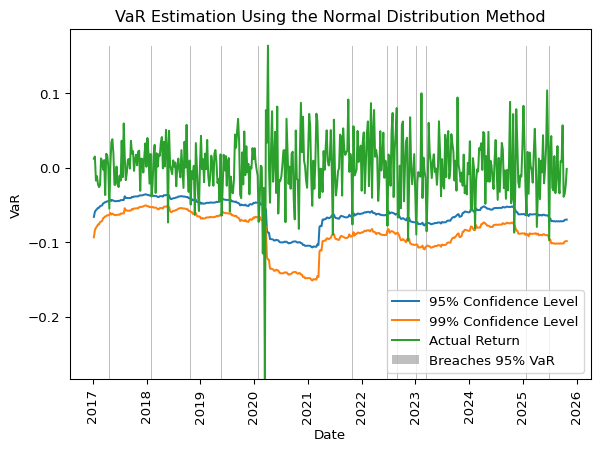

VaR Estimation Using the Normal Distribution Method with 95% confidence interval:
Breaches: 25
Backtesting (Realized VaR - % breaches): 5.4%

VaR Estimation Using the Normal Distribution Method with 99% confidence interval:
Breaches: 10
Backtesting (Realized VaR - % breaches): 2.2%


In [14]:
NAME = 'EQNR'
ESTIMATION_WINSIZE = 52

df = pd.read_pickle('data/X.df')


(normal95, normal99, 
 sigma, dates, ret )= generate_backtest(normal_est, 
        df, NAME, ESTIMATION_WINSIZE)
evaluate(plt, normal95, normal99, ret, dates,
         'VaR Estimation Using the Normal Distribution Method')